# Notebook 1: Arquitecturas Densas

En este primer notebook vamos a abordar distantas configuraciones para redes densas no convulucionales, con el objetivo de encontrar la configuración que ofrece un menor error cuadrático en el conjunto de pruebas. Haremos uso de las funciones auxiliares proporcionadas en los notebooks anteriores.  

La base de datos usada es un subconjunto de la base de datos
"Labeled Faces in the Wild" ("LFW"):

  http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz

  http://vis-www.cs.umass.edu/lfw/

La separación en carpetas "female" / "male" se ha realizado usando
un código basado en:
https://github.com/Pletron/LFWgender

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix
import os
from PIL import Image

In [2]:
COLAB = True

### Descarga de datos

In [3]:
if COLAB:
    aux = "'https://drive.usercontent.google.com/download?id=1kD_GKuU2doz3TSNVi45_BbwvDZ2KmEei&export=download&confirm=t&uuid=56f4f47a-291b-4ef9-895f-8886caf14b78'"
    !wget $aux -O ./gender.zip
    !unzip -qq ./gender.zip

--2025-01-04 12:51:49--  https://drive.usercontent.google.com/download?id=1kD_GKuU2doz3TSNVi45_BbwvDZ2KmEei&export=download&confirm=t&uuid=56f4f47a-291b-4ef9-895f-8886caf14b78
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 173.194.215.132, 2607:f8b0:400c:c0c::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|173.194.215.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 41914348 (40M) [application/octet-stream]
Saving to: ‘./gender.zip’

./gender.zip        100%[===================>]  39.97M  72.2MB/s    in 0.6s    

2025-01-04 12:51:52 (72.2 MB/s) - ‘./gender.zip’ saved [41914348/41914348]



In [4]:
if COLAB:
    from google_drive_downloader import GoogleDriveDownloader as gdd
    gdd.download_file_from_google_drive(file_id='1jifedd49sgZI2ZA6722h9R-mRh2Ciqzp',
                                        dest_path='./caras_aux.py.zip', unzip=True)
    gdd.download_file_from_google_drive(file_id='1w6rSNy0mDds1cDNBtbL9U1bkF4PiGCnK',
                                        dest_path='./funciones_auxiliares.py.zip', unzip=True)

Unzipping...Done.
Unzipping...Done.


## **Funciones auxiliares**

In [5]:
from IPython.display import SVG
from keras.utils import model_to_dot
from matplotlib.ticker import MaxNLocator

def display_model(model):
    if COLAB:
        display(SVG(model_to_dot(model, show_shapes=True,dpi=72).create(prog='dot', format='svg')))
    else:
        display(SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg')))

def grafica_entrenamiento(tr_acc, val_acc, tr_loss, val_loss,
                          figsize=(10,4)):
    best_i = np.argmax(val_acc)
    plt.figure(figsize=figsize)
    ax = plt.subplot(1,2,1)
    plt.plot(1+np.arange(len(tr_acc)),  100*np.array(tr_acc))
    plt.plot(1+np.arange(len(val_acc)), 100*np.array(val_acc))
    plt.plot(1+best_i, 100*val_acc[best_i], 'or')
    plt.title('tasa de acierto del modelo (%)', fontsize=18)
    plt.ylabel('tasa de acierto (%)', fontsize=18)
    plt.xlabel('época', fontsize=18)
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.subplot(1,2,2)
    plt.plot(1+np.arange(len(tr_acc)), np.array(tr_loss))
    plt.plot(1+np.arange(len(val_acc)), np.array(val_loss))
    plt.plot(1+best_i, val_loss[best_i], 'or')
    plt.title('loss del modelo', fontsize=18)
    plt.ylabel('loss', fontsize=18)
    plt.xlabel('época', fontsize=18)
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()

def loadImages_color(root, factor=1, nimages=False, color=False):
    files = os.listdir(root)
    if not nimages:
        nimages = len(files)
    if not color:
        X = np.zeros((nimages, int(factor*250)*int(factor*250)))
    else:
        X = np.zeros((nimages, 3*int(factor*250)*int(factor*250)))
    for i in range(nimages):
        f = os.path.join(root, files[i])
        if not color:
            img = Image.open(f).convert('L')
        else:
            img = Image.open(f)
        dims = np.shape(img)
        if i==0:
            h = int(factor*dims[0])
            w = int(factor*dims[1])
        img = img.resize((h, w))
        X[i,:] = np.ravel(img)
    return X, h, w

## **Exploración de datos**

Empezamos tomando un total de 2000 muestras.


Estadísticas básicas de la base de datos leída:
  # Clases: 2
  # Patrones: 2000
  # Atributos (features): 62500

Algunas imágenes de la clase "female":


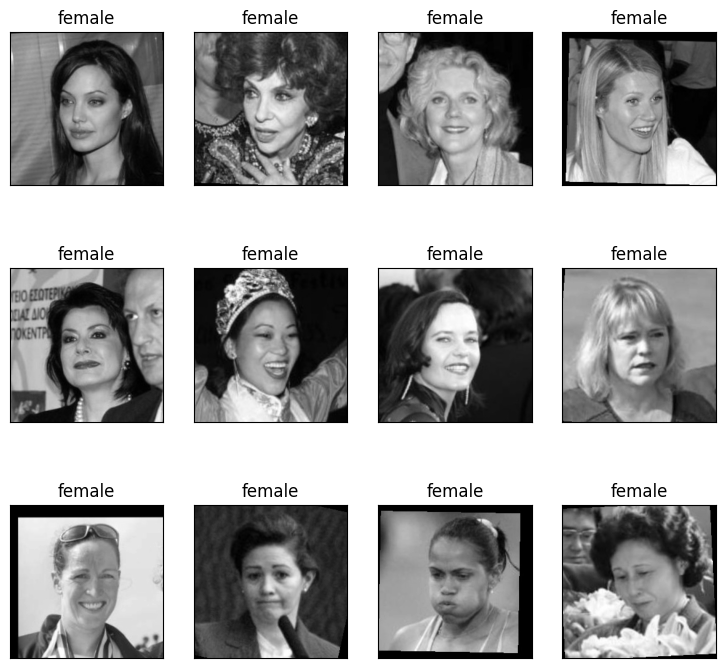


Algunas imágenes de la clase "male":


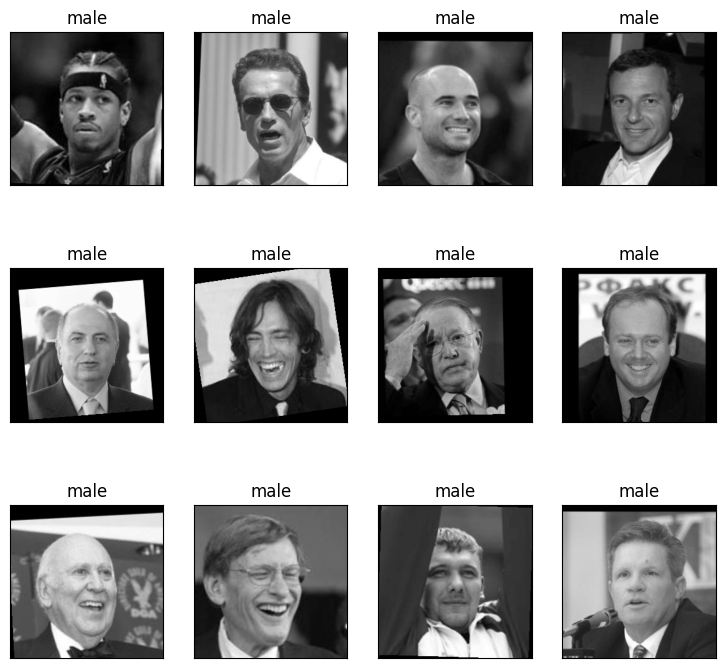

(3, 4)

In [6]:
from caras_aux import loadImages, plot_gallery


factor = 1
X_clase0, height, width = loadImages('./gender/female',
                                     factor=factor, nimages=1000)
X_clase1, height, width = loadImages('./gender/male',
                                     factor=factor, nimages=1000)
X = np.concatenate((X_clase0, X_clase1))
n_samples, n_features = X.shape

target_names = np.array(['female', 'male'])
n_classes = len(target_names)
N0 = len(X_clase0); N1 = len(X_clase1)
y = N0*[0] + N1*[1]
y = np.array(y)

print('\nEstadísticas básicas de la base de datos leída:')
print('  # Clases: %d' % n_classes)
print('  # Patrones: %d' % n_samples)
print('  # Atributos (features): %d' % n_features)

print('\nAlgunas imágenes de la clase "female":')
plot_gallery(X_clase0[:12].reshape((12, height, width)),
             12*['female'], cmap=plt.cm.gray)
print('\nAlgunas imágenes de la clase "male":')
plot_gallery(X_clase1[:12].reshape((12, height, width)),
             12*['male'], cmap=plt.cm.gray)

In [7]:
print(f"Formato entradas: {X.shape}")
print(f"Formato salidas: {y.shape}")

Formato entradas: (2000, 62500)
Formato salidas: (2000,)


## **Implementación en Keras de un modelo que clasifique una cara en gris en female / male**

En la siguiente celda se definen algunas funciones que facilitarán la parametrización del modelo. Entre ellas se define la función de cargar los datos, que permite elegir el factor de normalización de las imágenes, así como si estas están a color o no.

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Conv2D, Flatten, MaxPooling2D, Input
from keras.optimizers import Adam, RMSprop
from keras.regularizers import L1, L2, L1L2
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from IPython.display import clear_output
from keras.models import load_model, save_model




# **Configuración inicial**
def cargar_datos(factor=0.1, color=False, n_female=1000, n_male=1000):

    if color:
      X_clase0, height, width = loadImages_color('./gender/female', factor=factor, nimages=n_female, color=color)
      X_clase1, _, _ = loadImages_color('./gender/male', factor=factor, nimages=n_male, color=color)
      X = np.concatenate((X_clase0, X_clase1))
      y = np.array([0] * len(X_clase0) + [1] * len(X_clase1))
      return X, y
    else:
      X_clase0, height, width = loadImages('./gender/female', factor=factor, nimages=n_female)
      X_clase1, _, _ = loadImages('./gender/male', factor=factor, nimages=n_male)
      X = np.concatenate((X_clase0, X_clase1))
      y = np.array([0] * len(X_clase0) + [1] * len(X_clase1))
      return X, y

def dividir_datos(X, y, test_size=0.2, val_size=0.25, normalize=True):
    X_trval, X_test, y_trval, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    X_tr, X_val, y_tr, y_val = train_test_split(X_trval, y_trval, test_size=val_size, random_state=9)
    if normalize:
        scaler = MinMaxScaler()
        X_tr = scaler.fit_transform(X_tr)
        X_val = scaler.transform(X_val)
        X_test = scaler.transform(X_test)
    return X_tr, X_val, X_test, y_tr, y_val, y_test

def crear_modelo_denso(X_tr, capas, optimizador, tasa_aprendizaje, regularizador=None, dropout=None):

  model = Sequential()
  model.add(Input(shape=(X_tr.shape[1],)))
  if dropout:
      model.add(Dropout(rate=dropout))

  for capa in capas:
        if regularizador == 'L1':
            reg = L1(0.002)
        elif regularizador == 'L2':
            reg = L2(0.01)
        elif regularizador == 'L1L2':
            reg = L1L2(l1=0.002, l2=0.01)
        else:
            reg = None

        model.add(Dense(capa, activation='relu', kernel_regularizer=reg))

  model.add(Dense(1, activation='sigmoid'))
  if optimizador == 'adam':
        optimizador_modelo = Adam(learning_rate=tasa_aprendizaje)
  elif optimizador == 'rmsprop':
        optimizador_modelo = RMSprop(learning_rate=tasa_aprendizaje)
  else:
      raise ValueError("Optimizador no soportado")

  model.compile(loss="binary_crossentropy", optimizer=optimizador_modelo, metrics=["accuracy"])

  model.summary()
  return model


## Probando distintas condiguraciones para el modelo denso

En esta celda se definen diferentes hiperparámetros, parametrizando por un lado la tasa de normalización y el color de las imágenes, así como distintas configuraciones para la red neuronal, modificando el número de capas, el optimizador, la tasa de aprendizaje, etc.

In [33]:
# Configuraciones de cargar_datos
parametros_datos = [
    {'tasa_compresion': 0.2, 'color': False},
    {'tasa_compresion': 0.8, 'color': False},
    {'tasa_compresion': 0.2, 'color': True},
    {'tasa_compresion': 0.8, 'color': True},
]

# Configuraciones de la red
configuraciones = [
    {
        'capas': [5, 10, 5],
        'optimizador': 'adam',
        'tasa_aprendizaje': 0.0001,
        'regularizador': 'L1L2',
        'dropout': None
    },
    {
        'capas': [10, 5],
        'optimizador': 'rmsprop',
        'tasa_aprendizaje': 0.0001,
        'regularizador': None,
        'dropout': 0.2
    },
    {
        'capas': [10, 10, 10],
        'optimizador': 'adam',
        'tasa_aprendizaje': 0.0001,
        'regularizador': 'L1',
        'dropout': None
    },
    {
        'capas': [10, 5, 10],
        'optimizador': 'rmsprop',
        'tasa_aprendizaje': 0.0001,
        'regularizador': 'L2',
        'dropout': 0.2
    }
]

# Lista para almacenar resultados
resultados = []
mejor_configuracion = None
max_accuracy = -1
mejor_modelo = None

# Parametrizar cargar_datos
for params_datos in parametros_datos:
    print(f"\nEvaluando con parámetros de datos: {params_datos}\n")
    X, y = cargar_datos(
            params_datos['tasa_compresion'],
            params_datos['color'],
            n_female=1000,
            n_male=1000
        )
    X_tr, X_val, X_test, y_tr, y_val, y_test = dividir_datos(X, y, 0.2, 0.3, True)

    # Configuraciones de la red
    for config in configuraciones:
        print(f"Entrenando modelo con configuración: {config}")

        # Crear el modelo
        model = crear_modelo_denso(
            X_tr,
            config['capas'],
            config['optimizador'],
            config['tasa_aprendizaje'],
            config['regularizador'],
            config['dropout']
        )

        # Definir callbacks
        modelpath = "current_dense_model.keras"
        checkpoint = ModelCheckpoint(
            modelpath, monitor='val_accuracy', verbose=0, save_best_only=True, mode='max'
        )
        early_stopping = EarlyStopping(
            monitor='val_accuracy', patience=10, restore_best_weights=True
        )
        callbacks_list = [checkpoint, early_stopping]

        # Entrenar el modelo
        model.fit(
            X_tr, y_tr,
            epochs=200,
            batch_size=32,
            callbacks=callbacks_list,
            verbose=0,
            validation_data=(X_val, y_val)
        )

        # Evaluar el modelo en test
        best_model = load_model(modelpath)  # Cargar el mejor modelo guardado durante el entrenamiento
        best_score = best_model.evaluate(X_test, y_test, verbose=0)

        print(f"Best Score en Test -> Loss: {best_score[0]}, Accuracy: {best_score[1]}")
        # Guardar los resultados
        configuracion_actual = {
            'Tasa Compresión': params_datos['tasa_compresion'],
            'Color': params_datos['color'],
            'Capas': config['capas'],
            'Optimizador': config['optimizador'],
            'Tasa de Aprendizaje': config['tasa_aprendizaje'],
            'Regularizador': config['regularizador'],
            'Dropout': config['dropout'],
            'Loss en Test': best_score[0],
            'Accuracy en Test': best_score[1]
        }
        resultados.append(configuracion_actual)

        # Actualizar la mejor configuración si es necesario
        if best_score[1] > max_accuracy:
            max_accuracy = best_score[1]
            mejor_configuracion = configuracion_actual
            mejor_modelo = best_model  # Guardamos el modelo con mejor desempeño

# Crear un DataFrame con los resultados
df_resultados = pd.DataFrame(resultados)

# Ordenar los resultados por Accuracy en Test
df_resultados = df_resultados.sort_values(by='Accuracy en Test', ascending=False)

# Mostrar la tabla final de resultados
print("Resultados de todas las configuraciones con todas las parametrizaciones de datos:")
print(df_resultados)

# Guardar la mejor configuración en un archivo JSON
if mejor_configuracion:
    with open("mejor_configuracion.json", "w") as f:
        json.dump(mejor_configuracion, f, indent=4)
    print("\nLa mejor configuración ha sido guardada en 'mejor_configuracion.json':")
    print(json.dumps(mejor_configuracion, indent=4))

# Guardar el mejor modelo en un archivo
if mejor_modelo:
    mejor_modelo.save("mejor_modelo.keras")
    print("\nEl modelo con la mejor configuración ha sido guardado como 'mejor_modelo.keras'.")



Evaluando con parámetros de datos: {'tasa_compresion': 0.2, 'color': False}

Entrenando modelo con configuración: {'capas': [5, 10, 5], 'optimizador': 'adam', 'tasa_aprendizaje': 0.0001, 'regularizador': 'L1L2', 'dropout': None}


Model: "sequential_61"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_228 (Dense)                    │ (None, 5)                   │          12,505 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_229 (Dense)                    │ (None, 10)                  │              60 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_230 (Dense)                    │ (None, 5)                   │              55 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_231 (Dense)                    │ (None, 1)                   │               6 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,626 (49.32 KB)

 Trainable params: 12,626 (49.32 KB)

 Non-trainable params: 0 (0.00 B)

Best Score en Test -> Loss: 0.8476096391677856, Accuracy: 0.6875
Entrenando modelo con configuración: {'capas': [10, 5], 'optimizador': 'rmsprop', 'tasa_aprendizaje': 0.0001, 'regularizador': None, 'dropout': 0.2}


Model: "sequential_62"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dropout_26 (Dropout)                 │ (None, 2500)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_232 (Dense)                    │ (None, 10)                  │          25,010 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_233 (Dense)                    │ (None, 5)                   │              55 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_234 (Dense)                    │ (None, 1)                   │               6 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,071 (97.93 KB)

 Trainable params: 25,071 (97.93 KB)

 Non-trainable params: 0 (0.00 B)

Best Score en Test -> Loss: 0.5154386758804321, Accuracy: 0.7574999928474426
Entrenando modelo con configuración: {'capas': [10, 10, 10], 'optimizador': 'adam', 'tasa_aprendizaje': 0.0001, 'regularizador': 'L1', 'dropout': None}


Model: "sequential_63"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_235 (Dense)                    │ (None, 10)                  │          25,010 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_236 (Dense)                    │ (None, 10)                  │             110 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_237 (Dense)                    │ (None, 10)                  │             110 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_238 (Dense)                    │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,241 (98.60 KB)

 Trainable params: 25,241 (98.60 KB)

 Non-trainable params: 0 (0.00 B)

Best Score en Test -> Loss: 0.6662365794181824, Accuracy: 0.7799999713897705
Entrenando modelo con configuración: {'capas': [10, 5, 10], 'optimizador': 'rmsprop', 'tasa_aprendizaje': 0.0001, 'regularizador': 'L2', 'dropout': 0.2}


Model: "sequential_64"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dropout_27 (Dropout)                 │ (None, 2500)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_239 (Dense)                    │ (None, 10)                  │          25,010 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_240 (Dense)                    │ (None, 5)                   │              55 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_241 (Dense)                    │ (None, 10)                  │              60 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_242 (Dense)                    │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,136 (98.19 KB)

 Trainable params: 25,136 (98.19 KB)

 Non-trainable params: 0 (0.00 B)

Best Score en Test -> Loss: 0.6262866854667664, Accuracy: 0.7774999737739563

Evaluando con parámetros de datos: {'tasa_compresion': 0.8, 'color': False}

Entrenando modelo con configuración: {'capas': [5, 10, 5], 'optimizador': 'adam', 'tasa_aprendizaje': 0.0001, 'regularizador': 'L1L2', 'dropout': None}


Model: "sequential_65"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_243 (Dense)                    │ (None, 5)                   │         200,005 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_244 (Dense)                    │ (None, 10)                  │              60 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_245 (Dense)                    │ (None, 5)                   │              55 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_246 (Dense)                    │ (None, 1)                   │               6 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 200,126 (781.74 KB)

 Trainable params: 200,126 (781.74 KB)

 Non-trainable params: 0 (0.00 B)

Best Score en Test -> Loss: 0.7667601704597473, Accuracy: 0.7900000214576721
Entrenando modelo con configuración: {'capas': [10, 5], 'optimizador': 'rmsprop', 'tasa_aprendizaje': 0.0001, 'regularizador': None, 'dropout': 0.2}


Model: "sequential_66"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dropout_28 (Dropout)                 │ (None, 40000)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_247 (Dense)                    │ (None, 10)                  │         400,010 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_248 (Dense)                    │ (None, 5)                   │              55 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_249 (Dense)                    │ (None, 1)                   │               6 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 400,071 (1.53 MB)

 Trainable params: 400,071 (1.53 MB)

 Non-trainable params: 0 (0.00 B)

Best Score en Test -> Loss: 0.6931353807449341, Accuracy: 0.5
Entrenando modelo con configuración: {'capas': [10, 10, 10], 'optimizador': 'adam', 'tasa_aprendizaje': 0.0001, 'regularizador': 'L1', 'dropout': None}


Model: "sequential_67"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_250 (Dense)                    │ (None, 10)                  │         400,010 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_251 (Dense)                    │ (None, 10)                  │             110 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_252 (Dense)                    │ (None, 10)                  │             110 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_253 (Dense)                    │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 400,241 (1.53 MB)

 Trainable params: 400,241 (1.53 MB)

 Non-trainable params: 0 (0.00 B)

Best Score en Test -> Loss: 0.7214369177818298, Accuracy: 0.7925000190734863
Entrenando modelo con configuración: {'capas': [10, 5, 10], 'optimizador': 'rmsprop', 'tasa_aprendizaje': 0.0001, 'regularizador': 'L2', 'dropout': 0.2}


Model: "sequential_68"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dropout_29 (Dropout)                 │ (None, 40000)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_254 (Dense)                    │ (None, 10)                  │         400,010 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_255 (Dense)                    │ (None, 5)                   │              55 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_256 (Dense)                    │ (None, 10)                  │              60 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_257 (Dense)                    │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 400,136 (1.53 MB)

 Trainable params: 400,136 (1.53 MB)

 Non-trainable params: 0 (0.00 B)

Best Score en Test -> Loss: 0.975007176399231, Accuracy: 0.5024999976158142

Evaluando con parámetros de datos: {'tasa_compresion': 0.2, 'color': True}

Entrenando modelo con configuración: {'capas': [5, 10, 5], 'optimizador': 'adam', 'tasa_aprendizaje': 0.0001, 'regularizador': 'L1L2', 'dropout': None}


Model: "sequential_69"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_258 (Dense)                    │ (None, 5)                   │          37,505 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_259 (Dense)                    │ (None, 10)                  │              60 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_260 (Dense)                    │ (None, 5)                   │              55 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_261 (Dense)                    │ (None, 1)                   │               6 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 37,626 (146.98 KB)

 Trainable params: 37,626 (146.98 KB)

 Non-trainable params: 0 (0.00 B)

Best Score en Test -> Loss: 0.655018150806427, Accuracy: 0.8324999809265137
Entrenando modelo con configuración: {'capas': [10, 5], 'optimizador': 'rmsprop', 'tasa_aprendizaje': 0.0001, 'regularizador': None, 'dropout': 0.2}


Model: "sequential_70"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dropout_30 (Dropout)                 │ (None, 7500)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_262 (Dense)                    │ (None, 10)                  │          75,010 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_263 (Dense)                    │ (None, 5)                   │              55 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_264 (Dense)                    │ (None, 1)                   │               6 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 75,071 (293.25 KB)

 Trainable params: 75,071 (293.25 KB)

 Non-trainable params: 0 (0.00 B)

Best Score en Test -> Loss: 0.4496961832046509, Accuracy: 0.7950000166893005
Entrenando modelo con configuración: {'capas': [10, 10, 10], 'optimizador': 'adam', 'tasa_aprendizaje': 0.0001, 'regularizador': 'L1', 'dropout': None}


Model: "sequential_71"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_265 (Dense)                    │ (None, 10)                  │          75,010 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_266 (Dense)                    │ (None, 10)                  │             110 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_267 (Dense)                    │ (None, 10)                  │             110 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_268 (Dense)                    │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 75,241 (293.91 KB)

 Trainable params: 75,241 (293.91 KB)

 Non-trainable params: 0 (0.00 B)

Best Score en Test -> Loss: 0.7869775891304016, Accuracy: 0.7275000214576721
Entrenando modelo con configuración: {'capas': [10, 5, 10], 'optimizador': 'rmsprop', 'tasa_aprendizaje': 0.0001, 'regularizador': 'L2', 'dropout': 0.2}


Model: "sequential_72"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dropout_31 (Dropout)                 │ (None, 7500)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_269 (Dense)                    │ (None, 10)                  │          75,010 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_270 (Dense)                    │ (None, 5)                   │              55 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_271 (Dense)                    │ (None, 10)                  │              60 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_272 (Dense)                    │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 75,136 (293.50 KB)

 Trainable params: 75,136 (293.50 KB)

 Non-trainable params: 0 (0.00 B)

Best Score en Test -> Loss: 0.6113331317901611, Accuracy: 0.8025000095367432

Evaluando con parámetros de datos: {'tasa_compresion': 0.8, 'color': True}

Entrenando modelo con configuración: {'capas': [5, 10, 5], 'optimizador': 'adam', 'tasa_aprendizaje': 0.0001, 'regularizador': 'L1L2', 'dropout': None}


Model: "sequential_73"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_273 (Dense)                    │ (None, 5)                   │         600,005 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_274 (Dense)                    │ (None, 10)                  │              60 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_275 (Dense)                    │ (None, 5)                   │              55 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_276 (Dense)                    │ (None, 1)                   │               6 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 600,126 (2.29 MB)

 Trainable params: 600,126 (2.29 MB)

 Non-trainable params: 0 (0.00 B)

Best Score en Test -> Loss: 1.2756916284561157, Accuracy: 0.6175000071525574
Entrenando modelo con configuración: {'capas': [10, 5], 'optimizador': 'rmsprop', 'tasa_aprendizaje': 0.0001, 'regularizador': None, 'dropout': 0.2}


Model: "sequential_74"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dropout_32 (Dropout)                 │ (None, 120000)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_277 (Dense)                    │ (None, 10)                  │       1,200,010 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_278 (Dense)                    │ (None, 5)                   │              55 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_279 (Dense)                    │ (None, 1)                   │               6 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,200,071 (4.58 MB)

 Trainable params: 1,200,071 (4.58 MB)

 Non-trainable params: 0 (0.00 B)

Best Score en Test -> Loss: 0.693148136138916, Accuracy: 0.4975000023841858
Entrenando modelo con configuración: {'capas': [10, 10, 10], 'optimizador': 'adam', 'tasa_aprendizaje': 0.0001, 'regularizador': 'L1', 'dropout': None}


Model: "sequential_75"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_280 (Dense)                    │ (None, 10)                  │       1,200,010 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_281 (Dense)                    │ (None, 10)                  │             110 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_282 (Dense)                    │ (None, 10)                  │             110 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_283 (Dense)                    │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,200,241 (4.58 MB)

 Trainable params: 1,200,241 (4.58 MB)

 Non-trainable params: 0 (0.00 B)

Best Score en Test -> Loss: 0.945995569229126, Accuracy: 0.7450000047683716
Entrenando modelo con configuración: {'capas': [10, 5, 10], 'optimizador': 'rmsprop', 'tasa_aprendizaje': 0.0001, 'regularizador': 'L2', 'dropout': 0.2}


Model: "sequential_76"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dropout_33 (Dropout)                 │ (None, 120000)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_284 (Dense)                    │ (None, 10)                  │       1,200,010 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_285 (Dense)                    │ (None, 5)                   │              55 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_286 (Dense)                    │ (None, 10)                  │              60 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_287 (Dense)                    │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,200,136 (4.58 MB)

 Trainable params: 1,200,136 (4.58 MB)

 Non-trainable params: 0 (0.00 B)

Best Score en Test -> Loss: 0.9877989292144775, Accuracy: 0.5024999976158142
Resultados de todas las configuraciones con todas las parametrizaciones de datos:
    Tasa Compresión  Color         Capas Optimizador  Tasa de Aprendizaje  \
8               0.2   True    [5, 10, 5]        adam               0.0001   
11              0.2   True   [10, 5, 10]     rmsprop               0.0001   
9               0.2   True       [10, 5]     rmsprop               0.0001   
6               0.8  False  [10, 10, 10]        adam               0.0001   
4               0.8  False    [5, 10, 5]        adam               0.0001   
2               0.2  False  [10, 10, 10]        adam               0.0001   
3               0.2  False   [10, 5, 10]     rmsprop               0.0001   
1               0.2  False       [10, 5]     rmsprop               0.0001   
14              0.8   True  [10, 10, 10]        adam               0.0001   
10              0.2   True  [10, 10, 10]        adam               0.00

In [ ]:
# Definir modelo con 1 neurona de salida

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.regularizers import L1, L2, L1L2
from keras.optimizers import Adam

model = Sequential()
model.add(Dropout(rate=0.2, input_shape=(X_tr.shape[1],)))
# Loss: entropía + 0.002*(|w0| + |w1| + ... en capa densa 1) + 0.01*(|w0|^2 + |w1|^2 + ... en capa densa 2)
model.add(Dense(5, activation='relu', # "primera capa densa"
                #input_shape=(X_tr.shape[1],),
                #kernel_regularizer=L1(0.002)
                ))
#model.add(Dense(5, activation='relu',
#                kernel_regularizer=L2(0.01)
#                ))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss="binary_crossentropy", optimizer=Adam(0.0001),
              #optimizer="adam",
              metrics=["accuracy"])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/regularization/dropout.py:42: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dropout (Dropout)                    │ (None, 2500)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 5)                   │          12,505 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,505 (48.85 KB)

 Trainable params: 12,505 (48.85 KB)

 Non-trainable params: 0 (0.00 B)

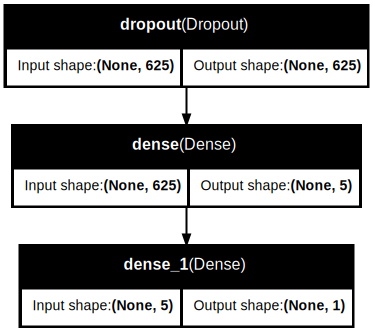

In [ ]:
display_model(model)

## **Entrenamiento del modelo**

In [ ]:
from keras.callbacks import ModelCheckpoint

serie_tr_acc = []
serie_val_acc = []
serie_tr_loss  = []
serie_val_loss = []

epochs = 500

modelpath="best_model.keras"

checkpoint = ModelCheckpoint(modelpath, monitor='val_accuracy', verbose=1,
                             save_best_only=True,
                             mode='max') # graba sólo los que mejoran en validación
callbacks_list = [checkpoint]

In [ ]:
from IPython.display import clear_output

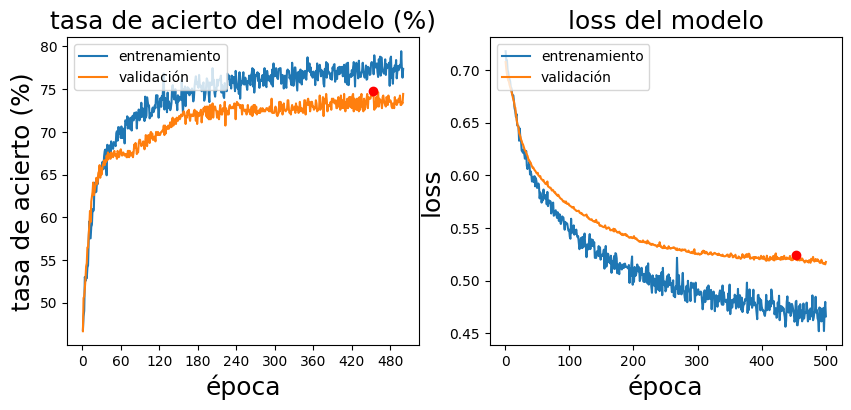

In [ ]:
for e in range(epochs):
    history = model.fit(X_tr, y_tr, epochs=1, batch_size=32, callbacks=callbacks_list,
                        verbose=10, validation_data=(X_val,y_val))

    serie_tr_acc.append(history.history['accuracy'][0])
    serie_val_acc.append(history.history['val_accuracy'][0])
    serie_tr_loss.append(history.history['loss'][0])
    serie_val_loss.append(history.history['val_loss'][0])

    if len(serie_tr_acc) % 2 == 0:
        clear_output()
    grafica_entrenamiento(serie_tr_acc, serie_val_acc, serie_tr_loss, serie_val_loss)

Recupero el mejor modelo (punto rojo), que está grabado en el fichero dado por la variable modelpath:

In [ ]:
modelpath

'best_model.keras'

In [ ]:
from keras.models import load_model

model = load_model(modelpath)

## **Análisis de los resultados del modelo**

In [ ]:
probs_predicciones_test = model.predict(X_test).flatten()
probs_predicciones_test[:5]

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


array([0.15888935, 0.548055  , 0.8947749 , 0.7391776 , 0.12619692],
      dtype=float32)

**Score (tasa de acierto, "accuracy") en test:**

In [ ]:
predicciones_test = np.round(probs_predicciones_test)

np.mean(y_test == predicciones_test)

0.795

Score en training:

In [ ]:
np.mean(y_tr == np.round(model.predict(X_tr).flatten()))

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


0.8103174603174603

Score en validación:

In [ ]:
np.mean(y_val == np.round(model.predict(X_val).flatten()))

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


0.7481481481481481

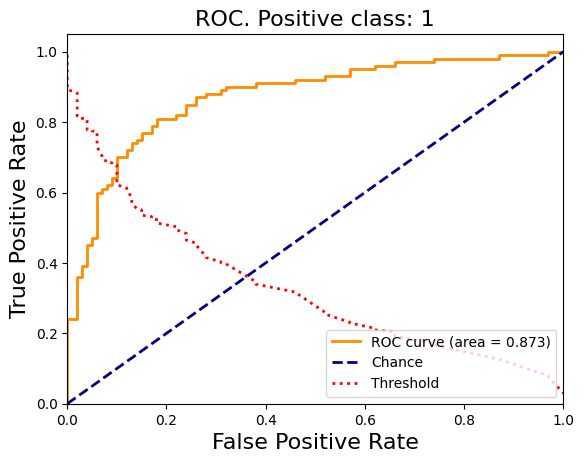

In [ ]:
analisis_roc(y=y_test, positive_class_scores=probs_predicciones_test, POSITIVE_CLASS=1)

Confusion matrix, without normalization
[[78 22]
 [19 81]]


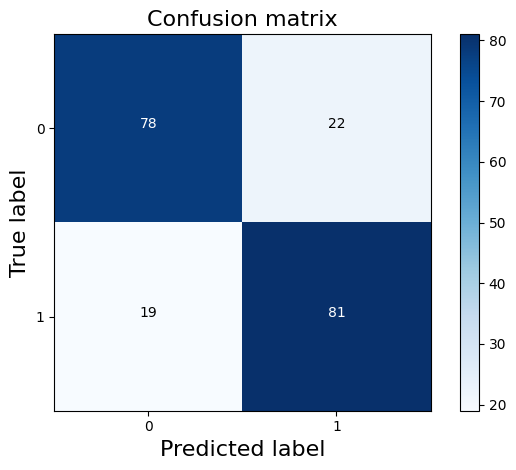

In [ ]:
plot_confusion_matrix(y=y_test, y_pred=predicciones_test)